In [1]:
# !pip freeze

In [2]:
GLOBAL_RANDOM_STATE = 158

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.externals import joblib
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Описание датасета: #

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы // ***Скорее всего ошибка перевода, и это налоговые штрафы, то есть списания штрафа со счета в пользу государства***
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
# raw_train_data = pd.read_csv("../data/course_project_train.csv")
# raw_test_data = pd.read_csv("../data/course_project_test.csv")

In [5]:
raw_train_data = pd.read_csv("./credit-default-prediction-ai-big-data/train.csv")
raw_test_data = pd.read_csv("./credit-default-prediction-ai-big-data/test.csv")

In [6]:
raw_train_data.head()

Id Home Ownership  Annual Income Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Months since last delinquent  Bankruptcies             Purpose        Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default
0   0       Own Home       482087.0                  NaN        0.0                     11.0                     26.3             685960.0                        1.0                           NaN           1.0  debt consolidation  Short Term           99999999.0                 47386.0        7914.0         749.0               0
1   1       Own Home      1025487.0            10+ years        0.0                     15.0                     15.3            1181730.0                        0.0                           NaN           0.0  debt consolidation   Long Term             264968.0                394972.0       18373.0         737.0               1
2   2  Home Mortgage       751412.0              8 years        0.0                     11.0                     35.0            1182434.0                        0.0                           NaN           0.0  debt consolidation  Short Term           99999999.0                308389.0       13651.0         742.0               0
3   3       Own Home       805068.0              6 years        0.0                      8.0                     22.5             147400.0                        1.0                           NaN           1.0  debt consolidation  Short Term             121396.0                 95855.0       11338.0         694.0               0
4   4           Rent       776264.0              8 years        0.0                     13.0                     13.6             385836.0                        1.0                           NaN           0.0  debt consolidation  Short Term             125840.0                 93309.0        7180.0         719.0               0

In [7]:
raw_test_data.head()

Id Home Ownership  Annual Income Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Months since last delinquent  Bankruptcies               Purpose        Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score
0  7500           Rent            NaN              4 years        0.0                      9.0                     12.5             220968.0                        0.0                          70.0           0.0    debt consolidation  Short Term             162470.0                105906.0        6813.0           NaN
1  7501           Rent       231838.0               1 year        0.0                      6.0                     32.7              55946.0                        0.0                           8.0           0.0  educational expenses  Short Term              78298.0                 46037.0        2318.0         699.0
2  7502  Home Mortgage      1152540.0              3 years        0.0                     10.0                     13.7             204600.0                        0.0                           NaN           0.0    debt consolidation  Short Term             200178.0                146490.0       18729.0        7260.0
3  7503  Home Mortgage      1220313.0            10+ years        0.0                     16.0                     17.0             456302.0                        0.0                          70.0           0.0    debt consolidation  Short Term             217382.0                213199.0       27559.0         739.0
4  7504  Home Mortgage      2340952.0              6 years        0.0                     11.0                     23.6            1207272.0                        0.0                           NaN           0.0    debt consolidation   Long Term             777634.0                425391.0       42605.0         706.0

In [8]:
train_data = raw_train_data.copy()
test_data = raw_test_data.copy()

In [9]:
list(raw_train_data.columns)

['Id',
 'Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [10]:
normalize_columns_names = []

# Наводим порядок в данных: #

## "Home Ownership" ##

In [11]:
train_data["Home Ownership"].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [12]:
test_data["Home Ownership"].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [13]:
# train data NAN values count
len(train_data.loc[train_data["Home Ownership"].isnull()])

0

In [14]:
# test data NAN values count
len(test_data.loc[test_data["Home Ownership"].isnull()])

0

#### Объединим схожие категории в одну: ####

In [15]:
train_data.loc[train_data['Home Ownership'] == "Have Mortgage", "Home Ownership"] = train_data["Home Ownership"].mode()[0]

In [16]:
test_data.loc[test_data['Home Ownership'] == "Have Mortgage", "Home Ownership"] = train_data["Home Ownership"].mode()[0]

In [17]:
train_data["Home Ownership"].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [18]:
test_data["Home Ownership"].value_counts()

Home Mortgage    1232
Rent             1020
Own Home          248
Name: Home Ownership, dtype: int64

#### Добавим дамми переменные на основе категорий из столбца "Home Ownership": ####

In [19]:
train_data = pd.concat([train_data, pd.get_dummies(train_data["Home Ownership"], prefix="HomeOwnership")], axis=1)

In [20]:
test_data = pd.concat([test_data, pd.get_dummies(test_data["Home Ownership"], prefix="HomeOwnership")], axis=1)

In [21]:
train_data.drop(columns=["Home Ownership", "HomeOwnership_Own Home"], inplace=True)
test_data.drop(columns=["Home Ownership", "HomeOwnership_Own Home"], inplace=True)

In [22]:
train_data.head()

Id  Annual Income Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Months since last delinquent  Bankruptcies             Purpose        Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent
0   0       482087.0                  NaN        0.0                     11.0                     26.3             685960.0                        1.0                           NaN           1.0  debt consolidation  Short Term           99999999.0                 47386.0        7914.0         749.0               0                            0                   0
1   1      1025487.0            10+ years        0.0                     15.0                     15.3            1181730.0                        0.0                           NaN           0.0  debt consolidation   Long Term             264968.0                394972.0       18373.0         737.0               1                            0                   0
2   2       751412.0              8 years        0.0                     11.0                     35.0            1182434.0                        0.0                           NaN           0.0  debt consolidation  Short Term           99999999.0                308389.0       13651.0         742.0               0                            1                   0
3   3       805068.0              6 years        0.0                      8.0                     22.5             147400.0                        1.0                           NaN           1.0  debt consolidation  Short Term             121396.0                 95855.0       11338.0         694.0               0                            0                   0
4   4       776264.0              8 years        0.0                     13.0                     13.6             385836.0                        1.0                           NaN           0.0  debt consolidation  Short Term             125840.0                 93309.0        7180.0         719.0               0                            0                   1

## "Annual Income" ##

In [23]:
train_data["Annual Income"].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [24]:
# train data NAN values count
len(train_data.loc[train_data["Annual Income"].isnull()])

1557

In [25]:
# test data NAN values count
len(test_data.loc[test_data["Annual Income"].isnull()])

513

In [26]:
AI_median = train_data["Annual Income"].median()
train_data["Annual Income"] = train_data["Annual Income"].fillna(AI_median)
test_data["Annual Income"] = test_data["Annual Income"].fillna(AI_median)

In [27]:
# train data NAN values count
len(train_data.loc[train_data["Annual Income"].isnull()])

0

In [28]:
# test data NAN values count
len(test_data.loc[test_data["Annual Income"].isnull()])

0

#### Считаю, что Annual Income нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [29]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Annual Income")

## "Years in current job" ##

In [30]:
train_data["Years in current job"].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [31]:
test_data["Years in current job"].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [32]:
# train_data[train_data.isnull().any(axis=1)]
len(train_data[train_data["Years in current job"].isnull()])

371

In [33]:
# test_data[test_data.isnull().any(axis=1)]
len(test_data[test_data["Years in current job"].isnull()])

86

In [34]:
YICJ_mode = train_data["Years in current job"].mode()[0]
train_data["Years in current job"] = train_data["Years in current job"].fillna(YICJ_mode)
test_data["Years in current job"] = test_data["Years in current job"].fillna(YICJ_mode)

In [35]:
# train_data[train_data.isnull().any(axis=1)]
len(train_data[train_data["Years in current job"].isnull()])

0

In [36]:
# test_data[test_data.isnull().any(axis=1)]
len(test_data[test_data["Years in current job"].isnull()])

0

#### Конвертируем строковые значения в числовые: ####

In [37]:
years_in_current_job_classes = {"< 1 year": "0", "1 year": "1", "2 years": "2", "3 years": "3", "4 years": "4", "5 years": "5", "6 years": "6", "7 years": "7", "8 years": "8", "9 years": "9", "10+ years": "10"}
train_data["Years in current job"] = train_data["Years in current job"].map(years_in_current_job_classes).astype(int)
test_data["Years in current job"] = test_data["Years in current job"].map(years_in_current_job_classes).astype(int)

#### Считаю, что Years in current job нужно нормализовать (на всякий случай) ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [38]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Years in current job")

## "Tax Liens" ##

In [39]:
train_data["Tax Liens"].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [40]:
test_data["Tax Liens"].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

In [41]:
train_data.loc[train_data['Tax Liens'] > 5, 'Tax Liens'] = 5
test_data.loc[test_data['Tax Liens'] > 5, 'Tax Liens'] = 5

In [42]:
train_data["Tax Liens"].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       5
Name: Tax Liens, dtype: int64

In [43]:
test_data["Tax Liens"].value_counts()

0.0    2445
1.0      45
2.0       5
5.0       3
3.0       1
4.0       1
Name: Tax Liens, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [44]:
len(train_data[train_data["Tax Liens"].isnull()])

0

In [45]:
len(test_data[test_data["Tax Liens"].isnull()])

0

#### Так как предполагаю, что этот столбец говорит о налоговых штрафах, и думаю, что его надо нормализовать, типо чем больше штрафов было, тем менее благонадежный клиент ####

In [46]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Tax Liens")

## "Number of Open Accounts" ##

In [47]:
train_data["Number of Open Accounts"].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [48]:
train_data["Number of Open Accounts"].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

In [49]:
test_data["Number of Open Accounts"].value_counts()

9.0     245
8.0     223
10.0    218
11.0    211
12.0    204
6.0     183
13.0    178
7.0     176
14.0    159
5.0     106
15.0     97
16.0     81
17.0     66
4.0      63
18.0     52
19.0     46
20.0     37
21.0     29
3.0      29
22.0     26
23.0     17
27.0     10
24.0      9
2.0       7
30.0      6
25.0      6
26.0      5
28.0      3
33.0      2
48.0      1
31.0      1
1.0       1
36.0      1
29.0      1
34.0      1
Name: Number of Open Accounts, dtype: int64

In [50]:
test_data["Number of Open Accounts"].describe()

count    2500.000000
mean       11.184400
std         4.852774
min         1.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        48.000000
Name: Number of Open Accounts, dtype: float64

In [51]:
train_data.loc[train_data['Number of Open Accounts'] > 30, 'Number of Open Accounts'] = 30
test_data.loc[test_data['Number of Open Accounts'] > 30, 'Number of Open Accounts'] = 30

#### Найдем и заполним отсутствующие значения: ####

In [52]:
len(train_data[train_data["Number of Open Accounts"].isnull()])

0

In [53]:
len(test_data[test_data["Number of Open Accounts"].isnull()])

0

#### Считаю, что Number of Open Accounts нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [54]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Number of Open Accounts")

## "Years of Credit History" ##

In [55]:
train_data["Years of Credit History"].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

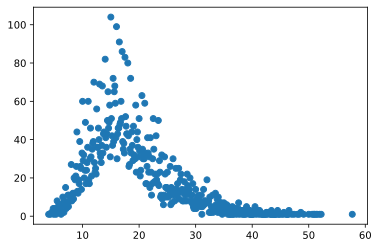

In [56]:
tmp_value_counts = train_data["Years of Credit History"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [57]:
test_data["Years of Credit History"].value_counts()

16.5    35
14.0    33
16.0    32
17.0    30
17.5    28
        ..
38.0     1
53.4     1
42.0     1
6.8      1
5.6      1
Name: Years of Credit History, Length: 345, dtype: int64

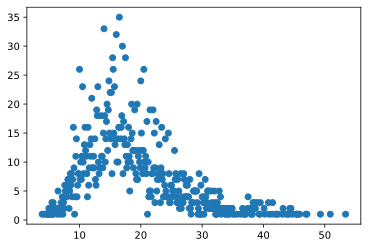

In [58]:
tmp_value_counts = test_data["Years of Credit History"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [59]:
train_data["Years of Credit History"].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

In [60]:
test_data["Years of Credit History"].describe()

count    2500.000000
mean       18.325920
std         7.254659
min         3.900000
25%        13.400000
50%        17.000000
75%        22.100000
max        53.400000
Name: Years of Credit History, dtype: float64

In [61]:
train_data.loc[train_data['Years of Credit History'] > 50, 'Years of Credit History'] = 50
test_data.loc[test_data['Years of Credit History'] > 50, 'Years of Credit History'] = 50

In [62]:
train_data["Years of Credit History"].describe()

count    7500.000000
mean       18.315187
std         7.030978
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        50.000000
Name: Years of Credit History, dtype: float64

In [63]:
test_data["Years of Credit History"].describe()

count    2500.000000
mean       18.324200
std         7.246801
min         3.900000
25%        13.400000
50%        17.000000
75%        22.100000
max        50.000000
Name: Years of Credit History, dtype: float64

#### Найдем и заполним отсутствующие значения: ####

In [64]:
len(train_data[train_data["Years of Credit History"].isnull()])

0

In [65]:
len(test_data[test_data["Years of Credit History"].isnull()])

0

#### Считаю, что Years of Credit History нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [66]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Years of Credit History")

## "Maximum Open Credit" ##

In [67]:
train_data["Maximum Open Credit"].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [68]:
train_data["Maximum Open Credit"].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [69]:
test_data["Maximum Open Credit"].value_counts()

0.0         14
252340.0     2
427064.0     2
286088.0     2
401522.0     2
            ..
785466.0     1
232100.0     1
382030.0     1
308550.0     1
247808.0     1
Name: Maximum Open Credit, Length: 2435, dtype: int64

In [70]:
test_data["Maximum Open Credit"].describe()

count    2.500000e+03
mean     7.105704e+05
std      1.511983e+06
min      0.000000e+00
25%      2.785860e+05
50%      4.786760e+05
75%      8.025985e+05
max      5.448439e+07
Name: Maximum Open Credit, dtype: float64

In [71]:
MOC_1_quantile = train_data["Maximum Open Credit"].quantile(0.01)
MOC_90_quantile = train_data["Maximum Open Credit"].quantile(0.9)
train_data.loc[train_data['Maximum Open Credit'] > MOC_90_quantile, 'Maximum Open Credit'] = MOC_90_quantile
test_data.loc[test_data['Maximum Open Credit'] > MOC_90_quantile, 'Maximum Open Credit'] = MOC_90_quantile
train_data.loc[train_data['Maximum Open Credit'] < MOC_1_quantile, 'Maximum Open Credit'] = MOC_1_quantile
test_data.loc[test_data['Maximum Open Credit'] < MOC_1_quantile, 'Maximum Open Credit'] = MOC_1_quantile

In [72]:
train_data["Maximum Open Credit"].describe()

count    7.500000e+03
mean     5.631106e+05
std      3.545437e+05
min      1.726978e+04
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.245904e+06
Name: Maximum Open Credit, dtype: float64

In [73]:
test_data["Maximum Open Credit"].describe()

count    2.500000e+03
mean     5.669160e+05
std      3.584253e+05
min      1.726978e+04
25%      2.785860e+05
50%      4.786760e+05
75%      8.025985e+05
max      1.245904e+06
Name: Maximum Open Credit, dtype: float64

#### Найдем и заполним отсутствующие значения: ####

In [74]:
len(train_data[train_data["Maximum Open Credit"].isnull()])

0

In [75]:
len(test_data[test_data["Maximum Open Credit"].isnull()])

0

#### Считаю, что Maximum Open Credit нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [76]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Maximum Open Credit")

## "Number of Credit Problems" ##

In [77]:
train_data["Number of Credit Problems"].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [78]:
test_data["Number of Credit Problems"].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [79]:
len(train_data[train_data["Number of Credit Problems"].isnull()])

0

In [80]:
len(test_data[test_data["Number of Credit Problems"].isnull()])

0

In [81]:
train_data.loc[train_data['Number of Credit Problems'] > 3, 'Number of Credit Problems'] = 3
test_data.loc[test_data['Number of Credit Problems'] > 3, 'Number of Credit Problems'] = 3

In [82]:
train_data["Number of Credit Problems"].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      56
Name: Number of Credit Problems, dtype: int64

In [83]:
test_data["Number of Credit Problems"].value_counts()

0.0    2177
1.0     280
2.0      29
3.0      14
Name: Number of Credit Problems, dtype: int64

#### Введу новый столбец, was_credit_problem который будет принимать значение 1, если была когда-нибудь проблема с кредитом, иначе 0: ####

In [84]:
train_data["was_credit_problem"] = np.where(train_data['Number of Credit Problems']>0, 1, 0)
test_data["was_credit_problem"] = np.where(test_data['Number of Credit Problems']>0, 1, 0)

## "Months since last delinquent" ##

In [85]:
train_data["Months since last delinquent"].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [86]:
train_data["Months since last delinquent"].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

#### Найдем и заполним отсутствующие значения: ####

In [87]:
len(train_data[train_data["Months since last delinquent"].isnull()])

4081

In [88]:
len(test_data[test_data["Months since last delinquent"].isnull()])

1358

#### Я буду рассматривать отсутствующие значения в этой колонке как то, что у человека ниразу не было просрочки, на основе чего завести новый бинарный признак была/нет просрочка когда-нибудь вообще или нет: ####

In [89]:
train_data["Months since last delinquent"].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [90]:
never_delinquent_value = 99999999
train_data["Months since last delinquent"] = train_data["Months since last delinquent"].fillna(never_delinquent_value)
test_data["Months since last delinquent"] = test_data["Months since last delinquent"].fillna(never_delinquent_value)

#### Введу новые столбцы с бинарной классификацией о просрочке за последние 0.5, 1, 2, 3, 5 лет и заполню их отталкиваясь от месяцев а так же новый столбец содержащий бинарный флаг о том была ли когда-нибудь вообще просрочка: ####
Логика заполнения такая - если просрочка была <= полгода назад - ставим во всех столбцах единицы; Если же последняя просрочка была три года назад, то ставим единицы в столбцах 3 и 5 лет (то есть просрочки были за последние 3 и 5 лет, но последние 0.5/1/2 лет просрочек не было).
Если просрочек никогда не было, то в столбце "delinquent" будет 0, иначе 1.

In [91]:
train_data["delinquent_0.5"] = train_data["Months since last delinquent"].astype(int)
train_data["delinquent_1"] = train_data["Months since last delinquent"].astype(int)
train_data["delinquent_2"] = train_data["Months since last delinquent"].astype(int)
train_data["delinquent_3"] = train_data["Months since last delinquent"].astype(int)
train_data["delinquent_5"] = train_data["Months since last delinquent"].astype(int)
train_data["delinquent"] = train_data["Months since last delinquent"].astype(int)

In [92]:
test_data["delinquent_0.5"] = test_data["Months since last delinquent"].astype(int)
test_data["delinquent_1"] = test_data["Months since last delinquent"].astype(int)
test_data["delinquent_2"] = test_data["Months since last delinquent"].astype(int)
test_data["delinquent_3"] = test_data["Months since last delinquent"].astype(int)
test_data["delinquent_5"] = test_data["Months since last delinquent"].astype(int)
test_data["delinquent"] = test_data["Months since last delinquent"].astype(int)

In [93]:
def fill_delinquent(x):
    months_since_last_delinquent = x["Months since last delinquent"]
    x["delinquent_5"] = 1 if months_since_last_delinquent <= 60 else 0
    x["delinquent_3"] = 1 if months_since_last_delinquent <= 36 else 0
    x["delinquent_2"] = 1 if months_since_last_delinquent <= 24 else 0
    x["delinquent_1"] = 1 if months_since_last_delinquent <= 12 else 0
    x["delinquent_0.5"] = 1 if months_since_last_delinquent <= 6 else 0
    x["delinquent"] = 1 if months_since_last_delinquent != never_delinquent_value else 0
    return x

In [94]:
train_data = train_data.apply(fill_delinquent, axis=1)
test_data = test_data.apply(fill_delinquent, axis=1)

In [95]:
train_data.drop(columns=["Months since last delinquent"], inplace=True)
test_data.drop(columns=["Months since last delinquent"], inplace=True)

## "Bankruptcies" ##

In [96]:
train_data["Bankruptcies"].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [97]:
test_data["Bankruptcies"].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [98]:
len(train_data[train_data["Bankruptcies"].isnull()])

14

In [99]:
len(test_data[test_data["Bankruptcies"].isnull()])

3

In [100]:
B_mode = train_data["Bankruptcies"].mode()[0]
train_data["Bankruptcies"] = train_data["Bankruptcies"].fillna(B_mode)
test_data["Bankruptcies"] = test_data["Bankruptcies"].fillna(B_mode)

In [101]:
len(train_data[train_data["Bankruptcies"].isnull()])

0

In [102]:
len(test_data[test_data["Bankruptcies"].isnull()])

0

In [103]:
train_data.loc[train_data['Bankruptcies'] > 3, 'Bankruptcies'] = 3
test_data.loc[test_data['Bankruptcies'] > 3, 'Bankruptcies'] = 3

#### Введу новый столбец, was_bankrupt который будет принимать значение 1, если был когда-нибудь банкротом, иначе 0: ####

In [104]:
train_data["was_bankrupt"] = np.where(train_data['Bankruptcies']>0, 1, 0)
test_data["was_bankrupt"] = np.where(test_data['Bankruptcies']>0, 1, 0)

## "Purpose" ##

In [105]:
train_data["Purpose"].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [106]:
test_data["Purpose"].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [107]:
len(train_data[train_data["Purpose"].isnull()])

0

In [108]:
len(test_data[test_data["Purpose"].isnull()])

0

In [109]:
purposes_to_other_list = ["small business", "wedding", "moving", "educational expenses", "vacation", "renewable energy", "major purchase", "take a trip", "buy house"]
train_data.loc[train_data["Purpose"].isin(purposes_to_other_list), "Purpose"] = "other"
test_data.loc[test_data["Purpose"].isin(purposes_to_other_list), "Purpose"] = "other"

In [110]:
train_data["Purpose"].value_counts()

debt consolidation    5944
other                  848
home improvements      412
business loan          129
buy a car               96
medical bills           71
Name: Purpose, dtype: int64

In [111]:
test_data["Purpose"].value_counts()

debt consolidation    1973
other                  296
home improvements      140
buy a car               34
business loan           30
medical bills           27
Name: Purpose, dtype: int64

#### Добавим дамми переменные на основе категорий из столбца "Purpose": ####

In [112]:
train_data = pd.concat([train_data, pd.get_dummies(train_data["Purpose"], prefix="Purpose")], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data["Purpose"], prefix="Purpose")], axis=1)

In [113]:
train_data.drop(columns=["Purpose", "Purpose_medical bills"], inplace=True)
test_data.drop(columns=["Purpose", "Purpose_medical bills"], inplace=True)

In [114]:
train_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies        Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other
0   0       482087.0                    10        0.0                     11.0                     26.3             685960.0                        1.0           1.0  Short Term           99999999.0                 47386.0        7914.0         749.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0
1   1      1025487.0                    10        0.0                     15.0                     15.3            1181730.0                        0.0           0.0   Long Term             264968.0                394972.0       18373.0         737.0               1                            0                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0
2   2       751412.0                     8        0.0                     11.0                     35.0            1182434.0                        0.0           0.0  Short Term           99999999.0                308389.0       13651.0         742.0               0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0
3   3       805068.0                     6        0.0                      8.0                     22.5             147400.0                        1.0           1.0  Short Term             121396.0                 95855.0       11338.0         694.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0
4   4       776264.0                     8        0.0                     13.0                     13.6             385836.0                        1.0           0.0  Short Term             125840.0                 93309.0        7180.0         719.0               0                            0                   1                   1               0             0             0             0             0           0             0                      0                  0                           1                          0              0

## "Term" ##

In [115]:
train_data["Term"].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [116]:
test_data["Term"].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

#### Найдем и заполним отсутствующие значения: ####

In [117]:
len(train_data[train_data["Term"].isnull()])

0

In [118]:
len(test_data[test_data["Term"].isnull()])

0

#### Конвертируем строковые значения в числовые: ####

In [119]:
term_classes = {"Short Term": "0", "Long Term": "1"}
train_data["Term"] = train_data["Term"].map(term_classes).astype(int)
test_data["Term"] = test_data["Term"].map(term_classes).astype(int)

In [120]:
train_data["Term"].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

In [121]:
test_data["Term"].value_counts()

0    1861
1     639
Name: Term, dtype: int64

## "Current Loan Amount", "Current Credit Balance", "Monthly Debt" ##

In [122]:
train_data["Current Loan Amount"].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [123]:
train_data["Current Loan Amount"].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [124]:
test_data["Current Loan Amount"].value_counts()

99999999.0    297
110462.0        3
396506.0        3
327404.0        3
258676.0        3
             ... 
543290.0        1
105578.0        1
43054.0         1
162448.0        1
450560.0        1
Name: Current Loan Amount, Length: 2026, dtype: int64

In [125]:
train_data["Current Loan Amount"].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

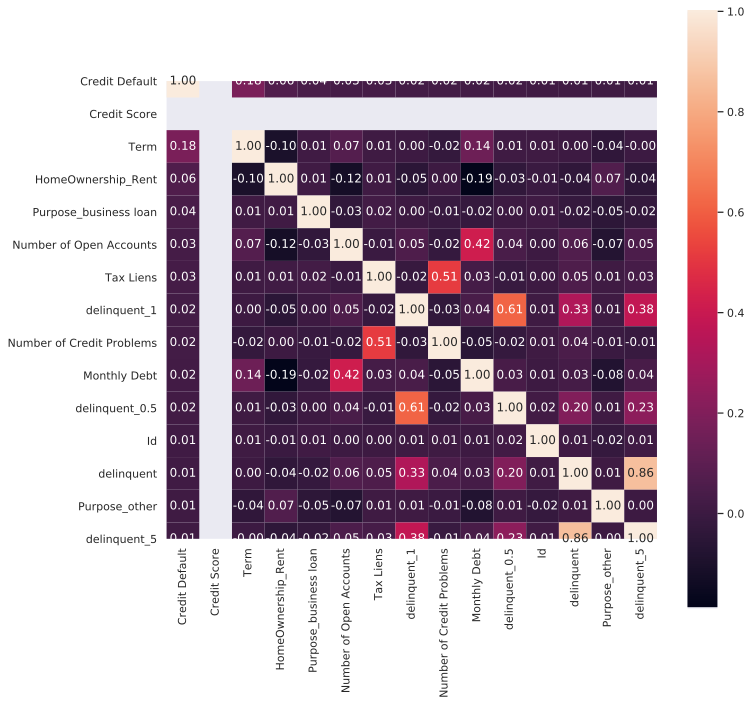

In [126]:
data = train_data.copy()
correlation = data.corr(method='pearson')
columns = correlation.nlargest(15, 'Credit Default').index
sns.set(rc={'figure.figsize':(11.,11.)})
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

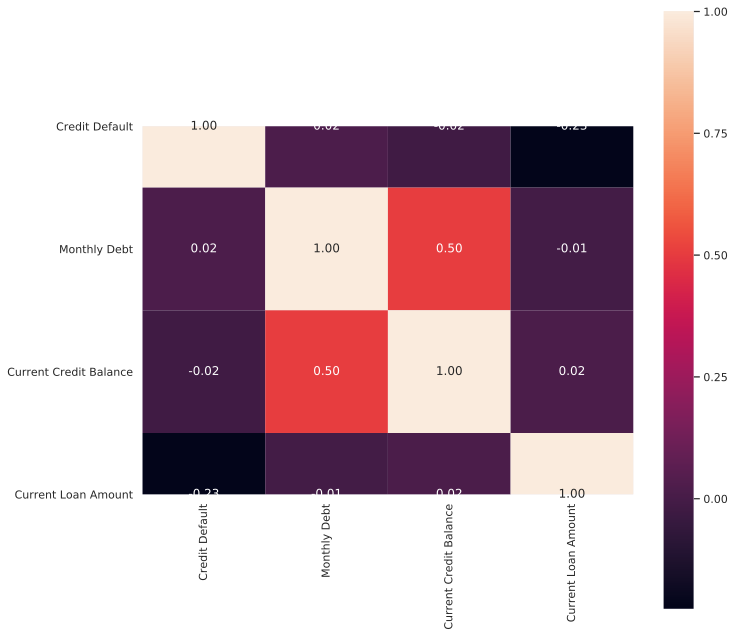

In [127]:
columns2 = pd.Index(['Credit Default', 'Monthly Debt', 'Current Credit Balance', 'Current Loan Amount'])
sns.set(rc={'figure.figsize':(11.,11.)})
correlation_map = np.corrcoef(data[columns2].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns2.values, xticklabels=columns2.values)

plt.show()

In [128]:
CLA_median = train_data.loc[train_data['Current Loan Amount'] <= 800000, "Current Loan Amount"].median()
CLA_median

265826.0

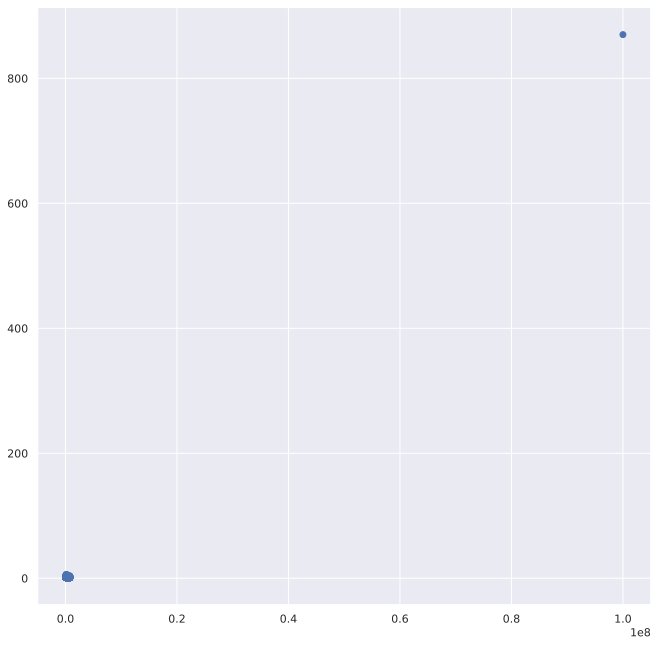

In [129]:
tmp_value_counts = train_data["Current Loan Amount"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

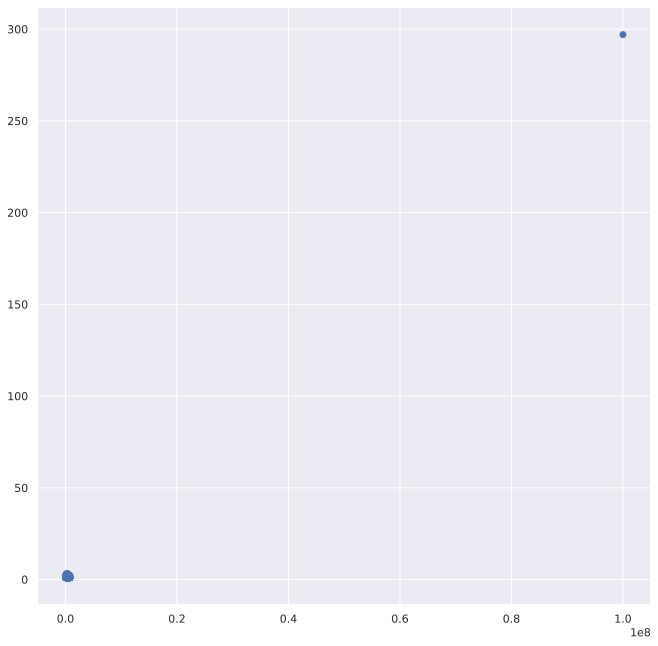

In [130]:
tmp_value_counts = test_data["Current Loan Amount"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [131]:
train_data.loc[train_data["Current Loan Amount"] > 800000, "Current Loan Amount"] = CLA_median
test_data.loc[test_data["Current Loan Amount"] > 800000, "Current Loan Amount"] = CLA_median

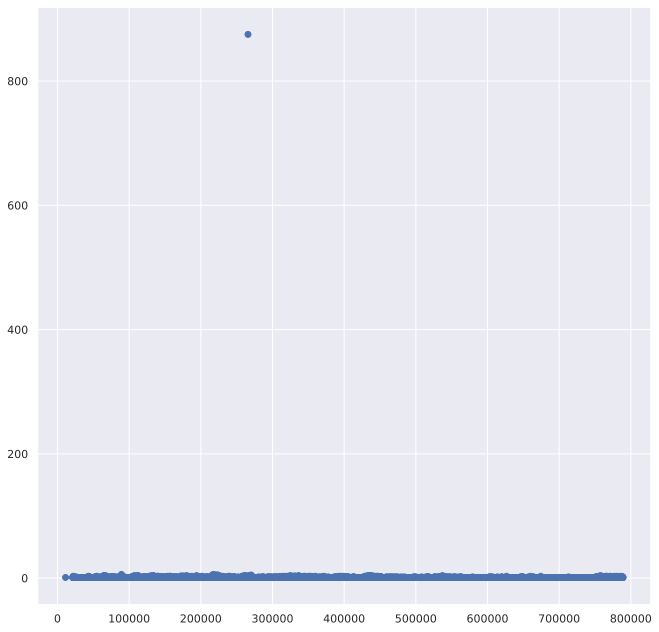

In [132]:
tmp_value_counts = train_data["Current Loan Amount"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

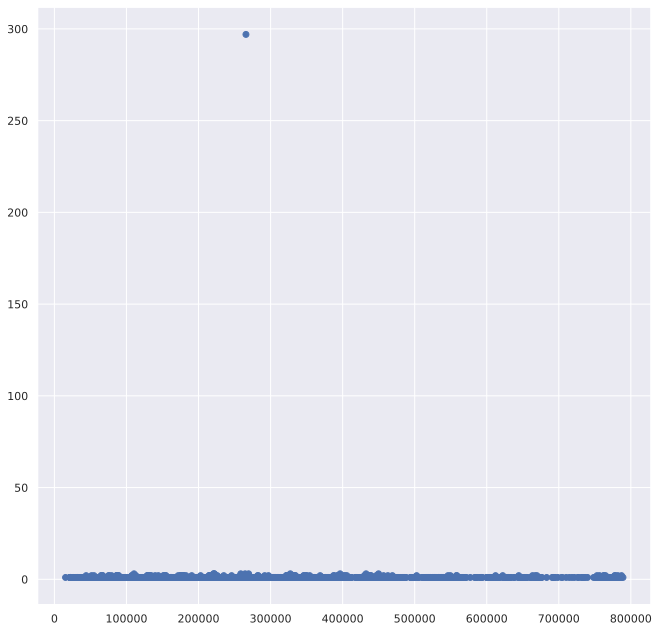

In [133]:
tmp_value_counts = test_data["Current Loan Amount"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [134]:
train_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other
0   0       482087.0                    10        0.0                     11.0                     26.3             685960.0                        1.0           1.0     0             265826.0                 47386.0        7914.0         749.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0
1   1      1025487.0                    10        0.0                     15.0                     15.3            1181730.0                        0.0           0.0     1             264968.0                394972.0       18373.0         737.0               1                            0                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0
2   2       751412.0                     8        0.0                     11.0                     35.0            1182434.0                        0.0           0.0     0             265826.0                308389.0       13651.0         742.0               0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0
3   3       805068.0                     6        0.0                      8.0                     22.5             147400.0                        1.0           1.0     0             121396.0                 95855.0       11338.0         694.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0
4   4       776264.0                     8        0.0                     13.0                     13.6             385836.0                        1.0           0.0     0             125840.0                 93309.0        7180.0         719.0               0                            0                   1                   1               0             0             0             0             0           0             0                      0                  0                           1                          0              0

In [135]:
test_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other
0  7500      1168386.0                     4        0.0                      9.0                     12.5             220968.0                        0.0           0.0     0             162470.0                105906.0        6813.0           NaN                            0                   1                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0
1  7501       231838.0                     1        0.0                      6.0                     32.7              55946.0                        0.0           0.0     0              78298.0                 46037.0        2318.0         699.0                            0                   1                   0               0             1             1             1             1           1             0                      0                  0                           0                          0              1
2  7502      1152540.0                     3        0.0                     10.0                     13.7             204600.0                        0.0           0.0     0             200178.0                146490.0       18729.0        7260.0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0
3  7503      1220313.0                    10        0.0                     16.0                     17.0             456302.0                        0.0           0.0     0             217382.0                213199.0       27559.0         739.0                            1                   0                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0
4  7504      2340952.0                     6        0.0                     11.0                     23.6            1207272.0                        0.0           0.0     1             777634.0                425391.0       42605.0         706.0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0

#### Считаю, что Current Loan Amount нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [136]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Current Loan Amount")

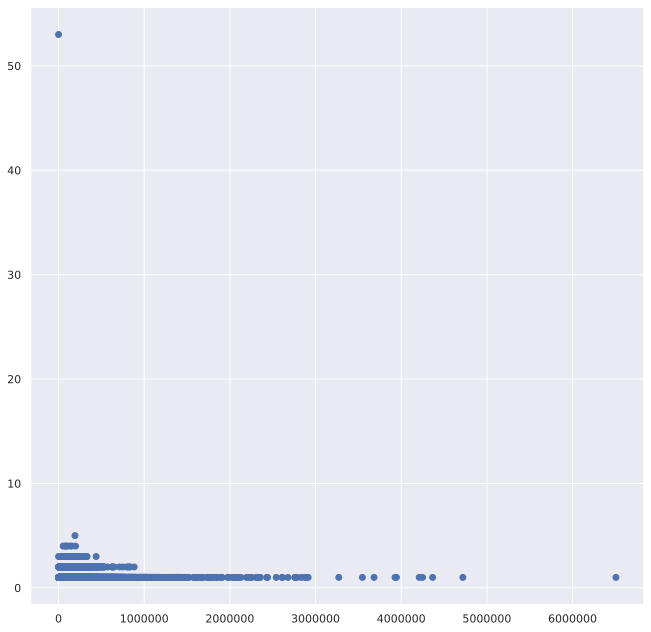

In [137]:
tmp_value_counts = train_data["Current Credit Balance"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

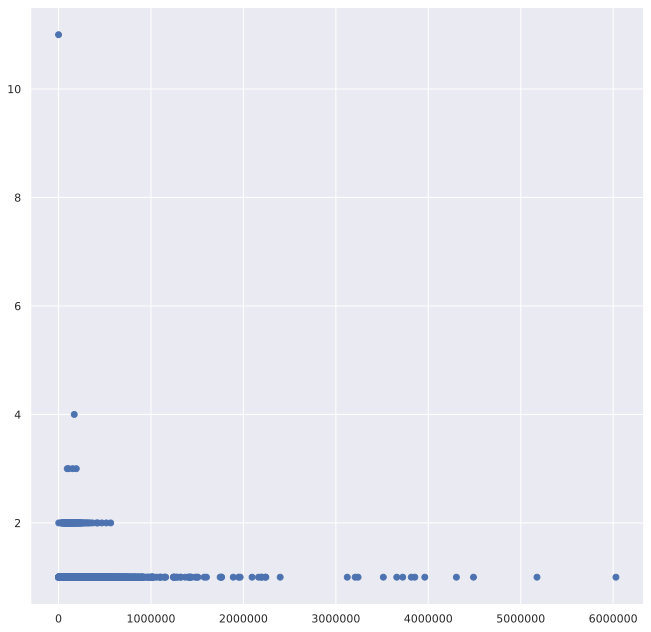

In [138]:
tmp_value_counts = test_data["Current Credit Balance"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [139]:
train_data.loc[train_data["Current Credit Balance"] > 2000000, "Current Credit Balance"] = 2000000
test_data.loc[test_data["Current Credit Balance"] > 2000000, "Current Credit Balance"] = 2000000
CCB_median = train_data["Current Credit Balance"].median()
train_data.loc[train_data["Current Credit Balance"] == 0, "Current Credit Balance"] = CCB_median
test_data.loc[test_data["Current Credit Balance"] == 0, "Current Credit Balance"] = CCB_median

#### Считаю, что Current Credit Balance нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [140]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Current Credit Balance")

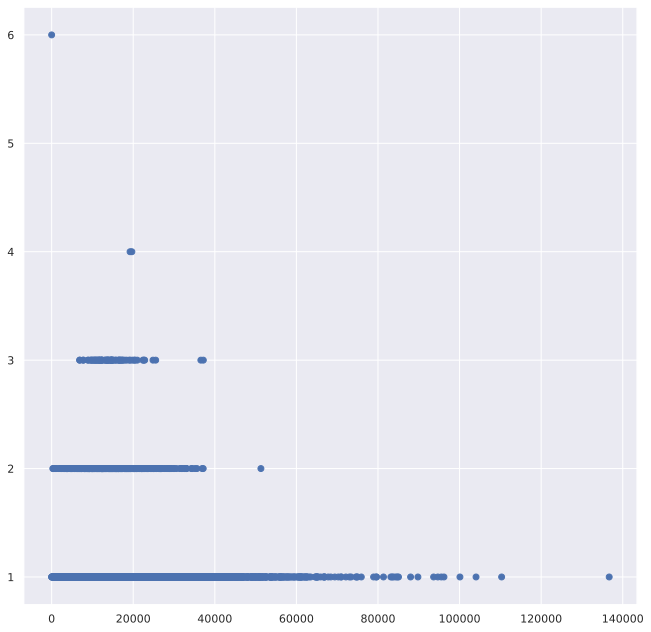

In [141]:
tmp_value_counts = train_data["Monthly Debt"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

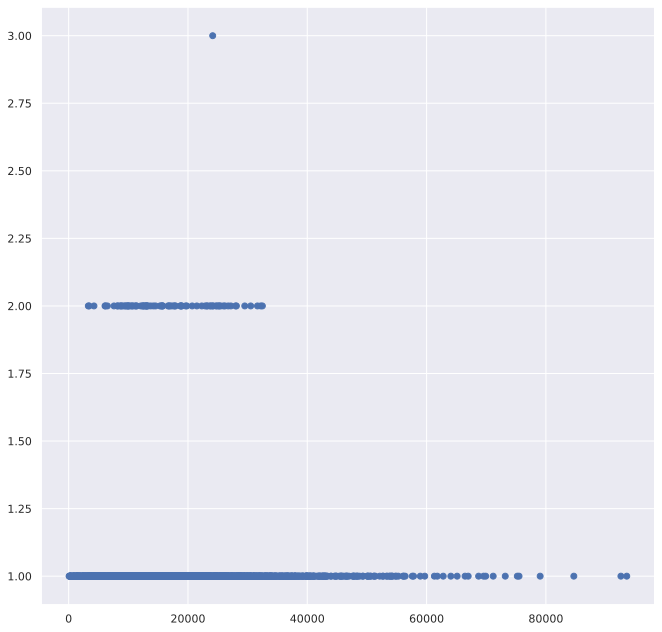

In [142]:
tmp_value_counts = test_data["Monthly Debt"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [143]:
train_data.loc[train_data["Monthly Debt"] > 80000, "Monthly Debt"] = 80000
test_data.loc[test_data["Monthly Debt"] > 80000, "Monthly Debt"] = 80000

#### Считаю, что Monthly Debt нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [144]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Monthly Debt")

## "Credit Score" ##

In [145]:
train_data["Credit Score"].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [146]:
train_data["Credit Score"].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

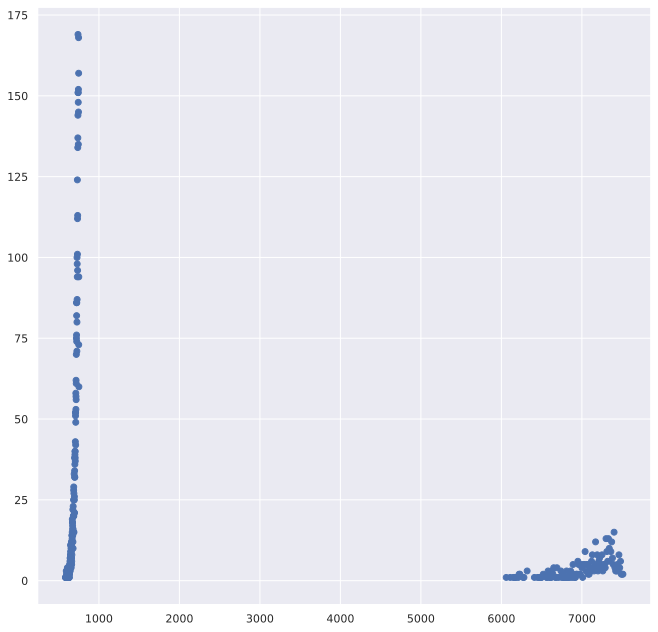

In [147]:
tmp_value_counts = train_data["Credit Score"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

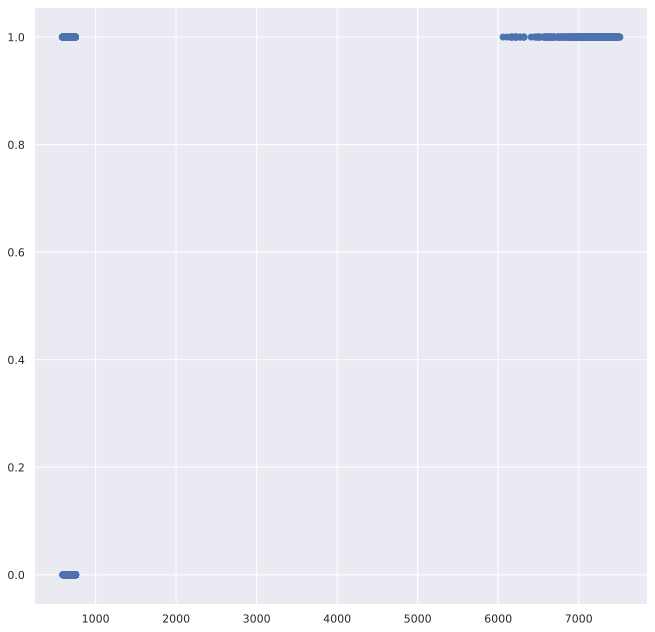

In [148]:
plt.scatter(train_data["Credit Score"], train_data["Credit Default"])

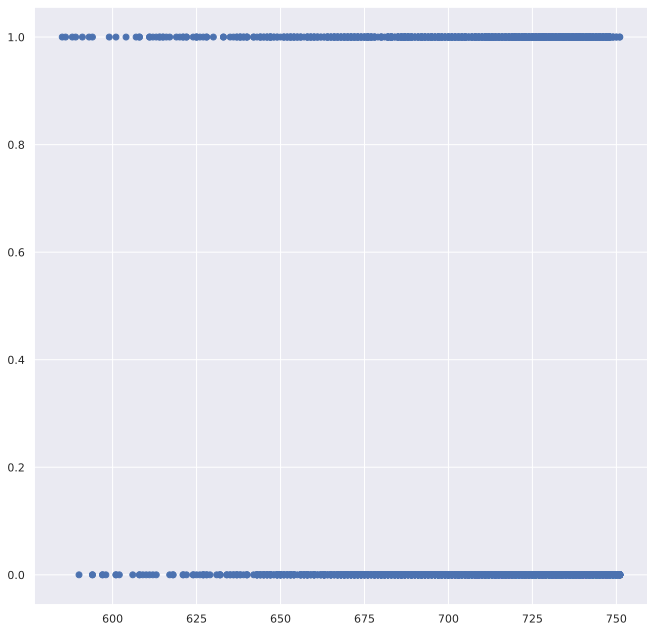

In [149]:
tmp_df = train_data.loc[train_data['Credit Score'] < 800, ["Credit Score", "Credit Default"]].copy()
plt.scatter(tmp_df["Credit Score"], tmp_df["Credit Default"])

In [150]:
test_data["Credit Score"].value_counts()

746.0     56
739.0     55
741.0     54
740.0     50
745.0     49
          ..
613.0      1
616.0      1
6880.0     1
6890.0     1
6670.0     1
Name: Credit Score, Length: 211, dtype: int64

In [151]:
test_data["Credit Score"].describe()

count    1987.000000
mean     1234.516860
std      1740.219442
min       585.000000
25%       710.000000
50%       731.000000
75%       743.000000
max      7480.000000
Name: Credit Score, dtype: float64

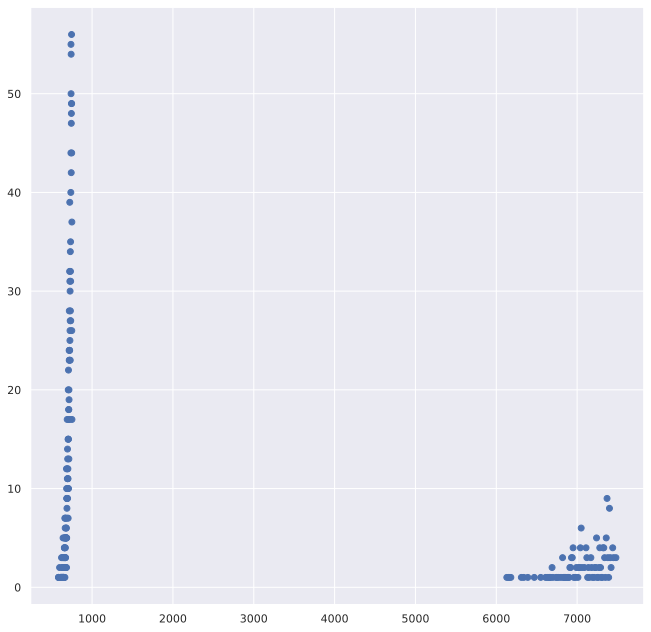

In [152]:
tmp_value_counts = test_data["Credit Score"].value_counts()
plt.scatter(tmp_value_counts.index, tmp_value_counts.values)

In [153]:
train_data.loc[train_data['Credit Score'] > 800, 'Credit Score'] = 1000
test_data.loc[test_data['Credit Score'] > 800, 'Credit Score'] = 1000

#### Найдем и заполним отсутствующие значения: ####

In [154]:
len(train_data[train_data["Credit Score"].isnull()])

1557

In [155]:
len(test_data[test_data["Credit Score"].isnull()])

513

In [156]:
CS_median = train_data["Credit Score"].median()
train_data["Credit Score"] = train_data["Credit Score"].fillna(CS_median)
test_data["Credit Score"] = test_data["Credit Score"].fillna(CS_median)

In [157]:
len(train_data[train_data["Credit Score"].isnull()])

0

In [158]:
len(test_data[test_data["Credit Score"].isnull()])

0

#### Введу новый столбец, very_bad_credit_score который будет принимать значение 1, если credit_score > 751, иначе 0: ####

In [159]:
train_data["very_bad_credit_score"] = np.where(train_data['Credit Score']>751, 1, 0)
test_data["very_bad_credit_score"] = np.where(test_data['Credit Score']>751, 1, 0)

In [160]:
train_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0   0       482087.0                    10        0.0                     11.0                     26.3             685960.0                        1.0           1.0     0             265826.0                 47386.0        7914.0         749.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
1   1      1025487.0                    10        0.0                     15.0                     15.3            1181730.0                        0.0           0.0     1             264968.0                394972.0       18373.0         737.0               1                            0                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
2   2       751412.0                     8        0.0                     11.0                     35.0            1182434.0                        0.0           0.0     0             265826.0                308389.0       13651.0         742.0               0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
3   3       805068.0                     6        0.0                      8.0                     22.5             147400.0                        1.0           1.0     0             121396.0                 95855.0       11338.0         694.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
4   4       776264.0                     8        0.0                     13.0                     13.6             385836.0                        1.0           0.0     0             125840.0                 93309.0        7180.0         719.0               0                            0                   1                   1               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

In [161]:
test_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0  7500      1168386.0                     4        0.0                      9.0                     12.5             220968.0                        0.0           0.0     0             162470.0                105906.0        6813.0         731.0                            0                   1                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
1  7501       231838.0                     1        0.0                      6.0                     32.7              55946.0                        0.0           0.0     0              78298.0                 46037.0        2318.0         699.0                            0                   1                   0               0             1             1             1             1           1             0                      0                  0                           0                          0              1                      0
2  7502      1152540.0                     3        0.0                     10.0                     13.7             204600.0                        0.0           0.0     0             200178.0                146490.0       18729.0        1000.0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      1
3  7503      1220313.0                    10        0.0                     16.0                     17.0             456302.0                        0.0           0.0     0             217382.0                213199.0       27559.0         739.0                            1                   0                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
4  7504      2340952.0                     6        0.0                     11.0                     23.6            1207272.0                        0.0           0.0     1             777634.0                425391.0       42605.0         706.0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

#### Считаю, что Credit Score нужно нормализовать ####
Нормализацию буду делать одновременно для всех колонок которым она требуется

In [162]:
# Добавляем имя столбца в список колонок которые будут нормализованы
normalize_columns_names.append("Credit Score")

# Делаем нормализацию: #

In [163]:
normalize_columns_names

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [164]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_data[normalize_columns_names])

std_scaler = StandardScaler()
std_scaler.fit(train_data[normalize_columns_names])

train_data_minmax_scaled = train_data.copy()
train_data_minmax_scaled[normalize_columns_names] = minmax_scaler.transform(train_data_minmax_scaled[normalize_columns_names])

test_data_minmax_scaled = test_data.copy()
test_data_minmax_scaled[normalize_columns_names] = minmax_scaler.transform(test_data_minmax_scaled[normalize_columns_names])

train_data_std_scaled = train_data.copy()
train_data_std_scaled[normalize_columns_names] = std_scaler.transform(train_data_std_scaled[normalize_columns_names])

test_data_std_scaled = test_data.copy()
test_data_std_scaled[normalize_columns_names] = std_scaler.transform(test_data_std_scaled[normalize_columns_names])

In [165]:
train_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0   0       482087.0                    10        0.0                     11.0                     26.3             685960.0                        1.0           1.0     0             265826.0                 47386.0        7914.0         749.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
1   1      1025487.0                    10        0.0                     15.0                     15.3            1181730.0                        0.0           0.0     1             264968.0                394972.0       18373.0         737.0               1                            0                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
2   2       751412.0                     8        0.0                     11.0                     35.0            1182434.0                        0.0           0.0     0             265826.0                308389.0       13651.0         742.0               0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
3   3       805068.0                     6        0.0                      8.0                     22.5             147400.0                        1.0           1.0     0             121396.0                 95855.0       11338.0         694.0               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
4   4       776264.0                     8        0.0                     13.0                     13.6             385836.0                        1.0           0.0     0             125840.0                 93309.0        7180.0         719.0               0                            0                   1                   1               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

In [166]:
train_data_minmax_scaled.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0   0       0.031798                   1.0        0.0                 0.321429                 0.484783             0.544255                        1.0           1.0     0             0.327318                0.023684      0.098925      0.395181               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
1   1       0.086221                   1.0        0.0                 0.464286                 0.245652             0.947768                        0.0           0.0     1             0.326215                0.197478      0.229663      0.366265               1                            0                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
2   2       0.058771                   0.8        0.0                 0.321429                 0.673913             0.948341                        0.0           0.0     0             0.327318                0.154186      0.170637      0.378313               0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
3   3       0.064145                   0.6        0.0                 0.214286                 0.402174             0.105915                        1.0           1.0     0             0.141625                0.047918      0.141725      0.262651               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
4   4       0.061260                   0.8        0.0                 0.392857                 0.208696             0.299980                        1.0           0.0     0             0.147338                0.046645      0.089750      0.322892               0                            0                   1                   1               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

In [167]:
train_data_std_scaled.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  Credit Default  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0   0      -1.114304              1.075647  -0.113798                -0.024088                 1.135738             0.346523                        1.0           1.0     0            -0.222098               -0.869042     -0.884193      0.168679               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
1   1      -0.396190              1.075647  -0.113798                 0.801797                -0.428872             1.744949                        0.0           0.0     1            -0.227088                0.393484      0.007662     -0.011064               1                            0                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
2   2      -0.758385              0.526268  -0.113798                -0.024088                 2.373201             1.746935                        0.0           0.0     0            -0.222098                0.078991     -0.394990      0.063829               0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0
3   3      -0.687478             -0.023111  -0.113798                -0.643502                 0.595236            -1.172601                        1.0           1.0     0            -1.062102               -0.692989     -0.592223     -0.655145               0                            0                   0                   1               0             0             0             0             0           0             1                      0                  0                           1                          0              0                      0
4   4      -0.725543              0.526268  -0.113798                 0.388854                -0.670675            -0.500041                        1.0           0.0     0            -1.036256               -0.702237     -0.946782     -0.280679               0                            0                   1                   1               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

In [168]:
test_data.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0  7500      1168386.0                     4        0.0                      9.0                     12.5             220968.0                        0.0           0.0     0             162470.0                105906.0        6813.0         731.0                            0                   1                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
1  7501       231838.0                     1        0.0                      6.0                     32.7              55946.0                        0.0           0.0     0              78298.0                 46037.0        2318.0         699.0                            0                   1                   0               0             1             1             1             1           1             0                      0                  0                           0                          0              1                      0
2  7502      1152540.0                     3        0.0                     10.0                     13.7             204600.0                        0.0           0.0     0             200178.0                146490.0       18729.0        1000.0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      1
3  7503      1220313.0                    10        0.0                     16.0                     17.0             456302.0                        0.0           0.0     0             217382.0                213199.0       27559.0         739.0                            1                   0                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
4  7504      2340952.0                     6        0.0                     11.0                     23.6            1207272.0                        0.0           0.0     1             777634.0                425391.0       42605.0         706.0                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

In [169]:
test_data_minmax_scaled.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0  7500       0.100532                   0.4        0.0                 0.250000                 0.184783             0.165792                        0.0           0.0     0             0.194433                0.052944      0.085163      0.351807                            0                   1                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
1  7501       0.006734                   0.1        0.0                 0.142857                 0.623913             0.031479                        0.0           0.0     0             0.086214                0.023009      0.028975      0.274699                            0                   1                   0               0             1             1             1             1           1             0                      0                  0                           0                          0              1                      0
2  7502       0.098945                   0.3        0.0                 0.285714                 0.210870             0.152470                        0.0           0.0     0             0.242915                0.073236      0.234113      1.000000                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      1
3  7503       0.105733                   1.0        0.0                 0.500000                 0.282609             0.357334                        0.0           0.0     0             0.265034                0.106591      0.344488      0.371084                            1                   0                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
4  7504       0.217968                   0.6        0.0                 0.321429                 0.426087             0.968557                        0.0           0.0     1             0.985348                0.212688      0.532563      0.291566                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

In [170]:
test_data_std_scaled.head()

Id  Annual Income  Years in current job  Tax Liens  Number of Open Accounts  Years of Credit History  Maximum Open Credit  Number of Credit Problems  Bankruptcies  Term  Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  HomeOwnership_Home Mortgage  HomeOwnership_Rent  was_credit_problem  delinquent_0.5  delinquent_1  delinquent_2  delinquent_3  delinquent_5  delinquent  was_bankrupt  Purpose_business loan  Purpose_buy a car  Purpose_debt consolidation  Purpose_home improvements  Purpose_other  very_bad_credit_score
0  7500      -0.207346             -0.572489  -0.113798                -0.437031                -0.827136            -0.965087                        0.0           0.0     0            -0.823216               -0.656481     -0.978077     -0.100936                            0                   1                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
1  7501      -1.445013             -1.396558  -0.113798                -1.056444                 2.046056            -1.430567                        0.0           0.0     0            -1.312760               -0.873942     -1.361372     -0.580252                            0                   1                   0               0             1             1             1             1           1             0                      0                  0                           0                          0              1                      0
2  7502      -0.228287             -0.847179  -0.113798                -0.230560                -0.656451            -1.011256                        0.0           0.0     0            -0.603906               -0.509069      0.038018      3.928314                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      1
3  7503      -0.138724              1.075647  -0.113798                 1.008268                -0.187068            -0.301277                        0.0           0.0     0            -0.503848               -0.266764      0.790965      0.018893                            1                   0                   0               0             0             0             0             0           1             0                      0                  0                           1                          0              0                      0
4  7504       1.342223             -0.023111  -0.113798                -0.024088                 0.751697             1.816996                        0.0           0.0     1             2.754576                0.503974      2.073959     -0.475402                            1                   0                   0               0             0             0             0             0           0             0                      0                  0                           1                          0              0                      0

## Сохраним scaler-ы: ##

In [171]:
# СОХРАНИМ SCALER
print(joblib.dump(minmax_scaler, "minmax_scaler.save"))
print(joblib.dump(std_scaler, "std_scaler.save"))
print(joblib.dump(normalize_columns_names, "scaler.columns"))

['minmax_scaler.save']
['std_scaler.save']
['scaler.columns']


## Сохраним обработанные данные: ##

In [172]:
train_data_minmax_scaled.to_csv("course_project_train_FIXED_MINMAX_SCALED.csv", index=False)
test_data_minmax_scaled.to_csv("course_project_test_FIXED_MINMAX_SCALED.csv", index=False)

In [173]:
train_data_std_scaled.to_csv("course_project_train_FIXED_STD_SCALED.csv", index=False)
test_data_std_scaled.to_csv("course_project_test_FIXED_STD_SCALED.csv", index=False)